In [1]:
# !pip install nbformat

In [2]:
import os
import pandas as pd
import tensorflow as tf

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
metrics_baseline, metrics, metrics_ensemble, cv_metrics = {}, {}, {}, {}

2023-12-30 16:09:09.167765: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-30 16:09:09.167788: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Approach 1: remove seasonality (normalize by intraday averaging)

In [3]:
REMOVE_SEASONALITY = True
PLOT_CHARTS = True

/home/otestov/code/ml/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Feature Importance: model is not specified, using CatBoostRegressor


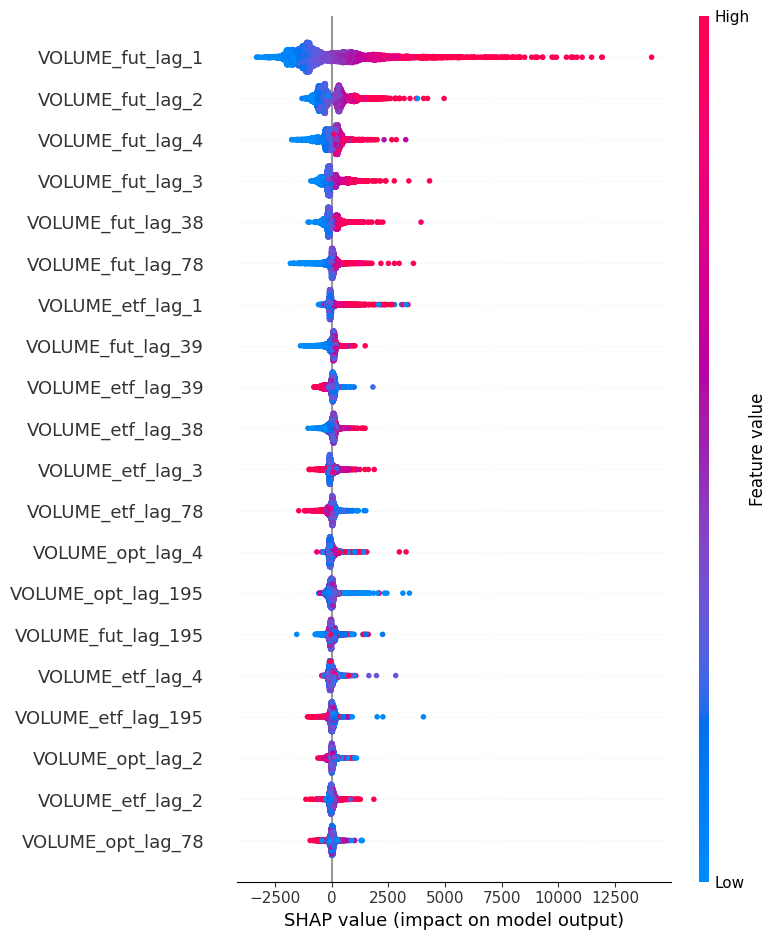

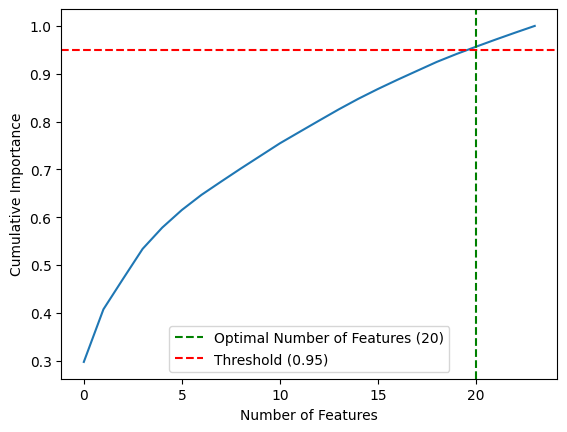

Training xgboost...
Best mean test score: -2126.228943039486
Training catboost...
Best mean test score: -2122.3004429195726
Training cascadeforest...
Best mean test score: -2184.707096938931
Training dnn...


2023-12-30 16:15:03.957670: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-12-30 16:15:03.957699: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-30 16:15:03.957715: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dev-host-1.eng.sol.onetick.com): /proc/driver/nvidia/version does not exist
2023-12-30 16:15:03.957939: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Best mean test score: -2238.8273807210176


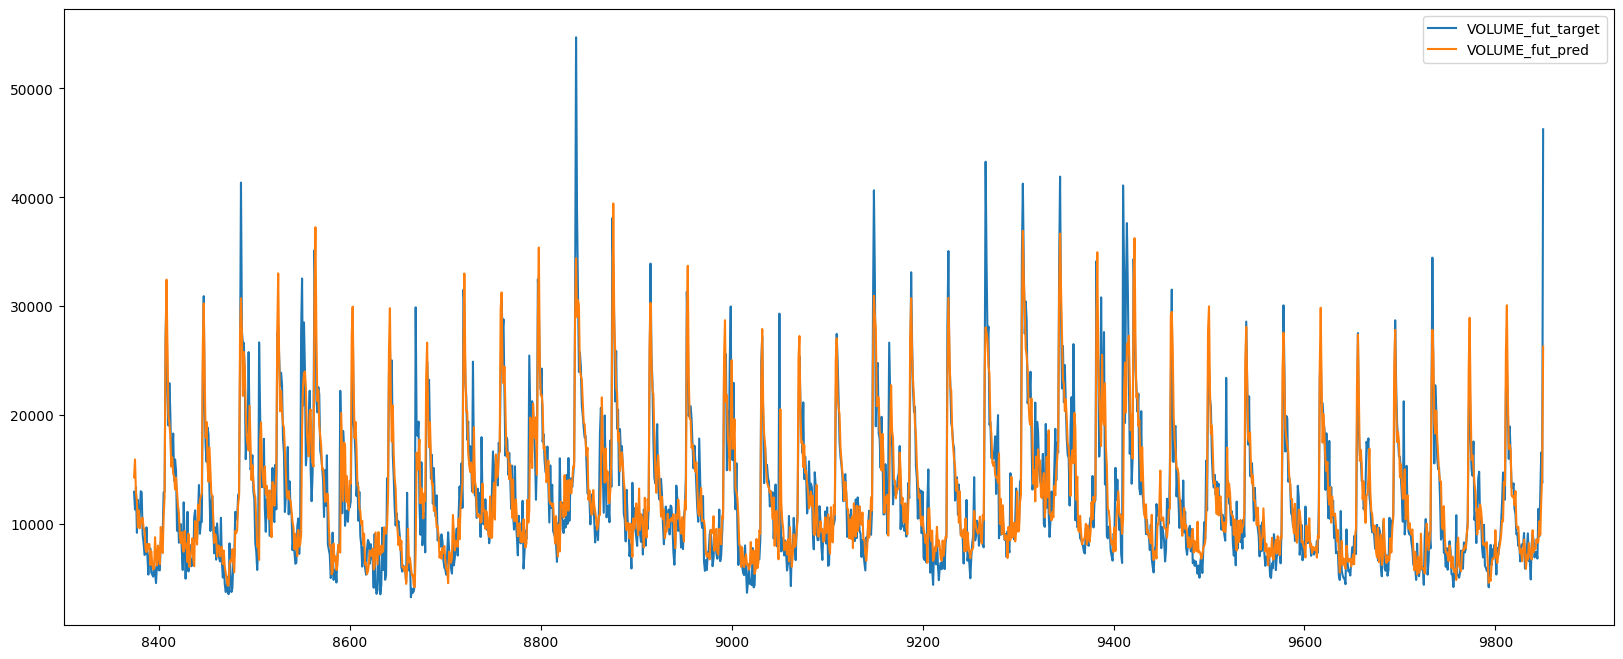

In [4]:
%run 2_experiment.ipynb

In [5]:
cv_metrics_ia = cv_metrics
cv_metrics_ia["approach"] = "IA"
cv_metrics_ia = cv_metrics_ia.loc[
    cv_metrics_ia.groupby("model")["mean_test_MAE"].idxmin()
].drop("params", axis=1)
cv_metrics_ia

,mean_test_MAE,std_test_MAE,mean_test_MAPE,std_test_MAPE,mean_test_R2,std_test_R2,model,approach
26,2184.707097,377.760402,0.211471,0.042192,0.797886,0.049827,cascadeforest,IA
3,2122.300443,320.547668,0.203411,0.028995,0.807317,0.044960,catboost,IA
28,2238.827381,421.387890,0.217032,0.043189,0.784047,0.099421,dnn,IA
0,2126.228943,316.663287,0.204616,0.026783,0.805216,0.040929,xgboost,IA


In [6]:
metrics_ia = pd.DataFrame({**metrics_baseline, **metrics, **metrics_ensemble}).T
metrics_ia.index += "_ia"
metrics_ia

,R2,MAE,MAPE
baseline_ia,0.690206,2619.460642,0.213686
xgboost_ia,0.755963,2284.220056,0.194245
catboost_ia,0.754837,2297.035766,0.193660
cascadeforest_ia,0.753333,2275.124707,0.189020
dnn_ia,0.757121,2297.334898,0.195917
ensemble_ia,0.759076,2268.190029,0.191476


# Approach 2: consider intraday seasonality by adding a time feature

In [7]:
REMOVE_SEASONALITY = False
PLOT_CHARTS = True

Feature Importance: model is not specified, using CatBoostRegressor


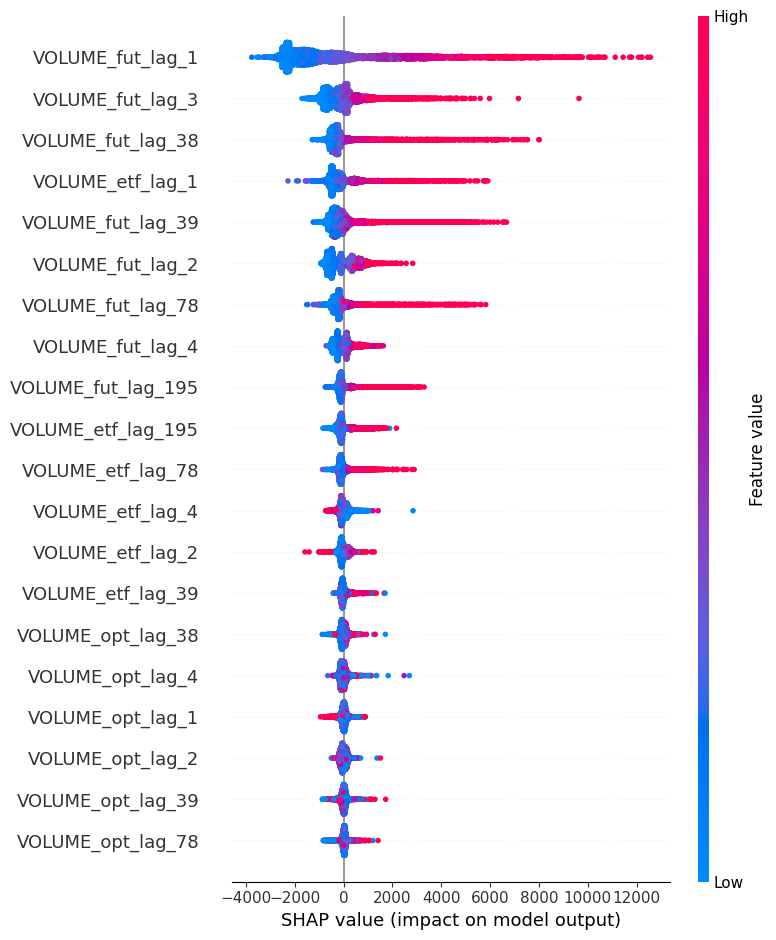

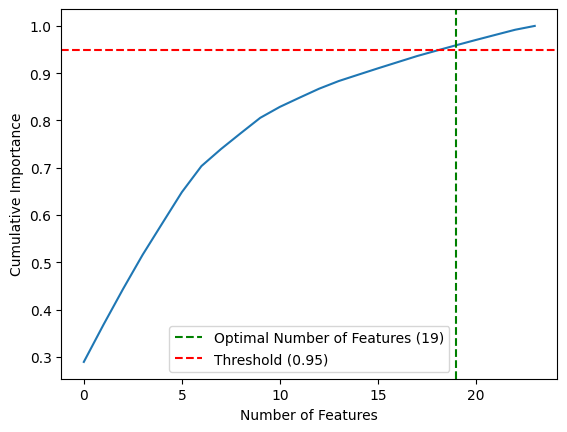

Training xgboost...
Best mean test score: -2138.7713031260514
Training catboost...
Best mean test score: -2165.580748101316
Training cascadeforest...
Best mean test score: -2181.654843839583
Training dnn...
Best mean test score: -2284.055876543705


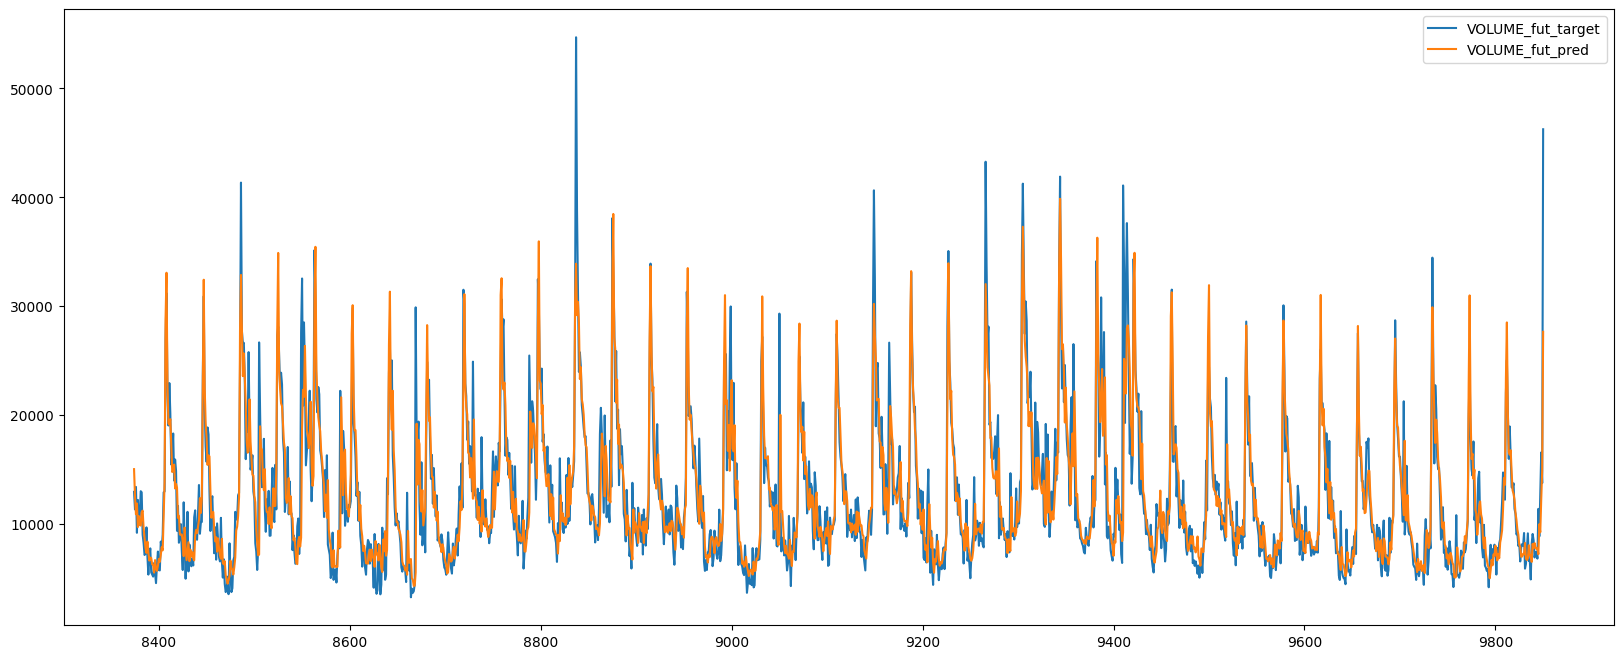

In [8]:
%run 2_experiment.ipynb

In [9]:
cv_metrics_hhmm = cv_metrics
cv_metrics_hhmm["approach"] = "HHMM"
cv_metrics_hhmm = cv_metrics_hhmm.loc[
    cv_metrics_hhmm.groupby("model")["mean_test_MAE"].idxmin()
].drop("params", axis=1)
cv_metrics_hhmm

,mean_test_MAE,std_test_MAE,mean_test_MAPE,std_test_MAPE,mean_test_R2,std_test_R2,model,approach
5,2181.654844,242.359929,0.214469,0.021966,0.794471,0.032761,cascadeforest,HHMM
3,2165.580748,271.134814,0.216428,0.022591,0.799432,0.027088,catboost,HHMM
28,2284.055877,342.379035,0.219041,0.033129,0.762242,0.065479,dnn,HHMM
0,2138.771303,257.952876,0.212973,0.022634,0.802458,0.025655,xgboost,HHMM


In [10]:
metrics_hhmm = pd.DataFrame({**metrics_baseline, **metrics, **metrics_ensemble}).T
metrics_hhmm.index += "_hhmm"
metrics_hhmm

,R2,MAE,MAPE
baseline_hhmm,0.627244,2791.738659,0.222814
xgboost_hhmm,0.763980,2219.090675,0.185100
catboost_hhmm,0.759199,2263.738515,0.191049
cascadeforest_hhmm,0.765104,2210.067961,0.182244
dnn_hhmm,0.749185,2257.498888,0.183750
ensemble_hhmm,0.767622,2190.814365,0.181871


# Comparison

## CV metrics

In [11]:
pd.concat([cv_metrics_ia, cv_metrics_hhmm]).sort_values("mean_test_MAE")

,mean_test_MAE,std_test_MAE,mean_test_MAPE,std_test_MAPE,mean_test_R2,std_test_R2,model,approach
3,2122.300443,320.547668,0.203411,0.028995,0.807317,0.044960,catboost,IA
0,2126.228943,316.663287,0.204616,0.026783,0.805216,0.040929,xgboost,IA
0,2138.771303,257.952876,0.212973,0.022634,0.802458,0.025655,xgboost,HHMM
3,2165.580748,271.134814,0.216428,0.022591,0.799432,0.027088,catboost,HHMM
5,2181.654844,242.359929,0.214469,0.021966,0.794471,0.032761,cascadeforest,HHMM
26,2184.707097,377.760402,0.211471,0.042192,0.797886,0.049827,cascadeforest,IA
28,2238.827381,421.387890,0.217032,0.043189,0.784047,0.099421,dnn,IA
28,2284.055877,342.379035,0.219041,0.033129,0.762242,0.065479,dnn,HHMM


## Test metrics

In [12]:
pd.concat([metrics_ia, metrics_hhmm]).sort_values("MAE")

,R2,MAE,MAPE
ensemble_hhmm,0.767622,2190.814365,0.181871
cascadeforest_hhmm,0.765104,2210.067961,0.182244
xgboost_hhmm,0.763980,2219.090675,0.185100
dnn_hhmm,0.749185,2257.498888,0.183750
catboost_hhmm,0.759199,2263.738515,0.191049
ensemble_ia,0.759076,2268.190029,0.191476
cascadeforest_ia,0.753333,2275.124707,0.189020
xgboost_ia,0.755963,2284.220056,0.194245
catboost_ia,0.754837,2297.035766,0.193660
dnn_ia,0.757121,2297.334898,0.195917
